In [1]:
sample = "5FU_FO892_4"
#template = "cCARLIN"
data_path = "/home/zhoujiaqi/data/zhoujiaqi/CARLIN/Processed/amplicon/fastq/"
output_dir = "/home/zhoujiaqi/data/zhoujiaqi/CARLIN/code/output/"
ref_dir ='/home/zhoujiaqi/data/zhoujiaqi/CARLIN/Analysis/5FU/FO892/SC/2/Transcriptome/filtered_barcodes_umi_mt.txt'
#CARLIN_read_cutoff=3 # used to compare with CARLIN pipeline
cfg="sc10xV3" # ['sc10xV3',  'scCamellia']
coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
distance_relative_threshold=0.03 # 5% error rate, will be multipled with the sequence length
read_ratio_threshold=0.6
#seq_3prime_upper_N=15
#seq_5prime_upper_N=None

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from mosaiclineage import DARLIN as car
from mosaiclineage import larry

/home/zhoujiaqi/miniconda2/envs/darlin/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
import importlib
importlib.reload(car)
importlib.reload(larry)
#%config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',100)
%matplotlib inline

# Single-cell CARLIN pipeline for 10x data

In [4]:
ref_name=cfg
df_ref_BC=pd.read_csv(f'{ref_dir}',
                      sep='\t',header=None,names=['CB'])

In [5]:
df_ref_BC

,CB
0,AAACCCAAGTTGAATG
1,AAACCCAGTGATAGAT
2,AAACCCATCAGCGGAA
3,AAACCCATCGCACTCT
4,AAACCCATCGCTGTTC
...,...
6020,TTTGTTGAGGGTAATT
6021,TTTGTTGAGTAGATCA
6022,TTTGTTGCACGATTCA
6023,TTTGTTGCATCACCAA


In [6]:
%%time
## load sequences
df_raw_reads=car.CARLIN_raw_reads(data_path+sample,sample,protocol=cfg)

CPU times: user 2min, sys: 2.49 s, total: 2min 2s
Wall time: 2min 3s


In [7]:
df_raw_reads

,cell_bc,cell_bc_quality_mean,cell_bc_quality_min,library,cell_id,umi,umi_quality_mean,umi_quality_min,umi_id,clone_id,clone_id_quality_mean,clone_id_quality_min
0,TTGTTCCCAGTGTATC,33.4375,18,5FU_FO892_4,5FU_FO892_4_TTGTTCCCAGTGTATC,CTGGTTTGCTCT,37.583333,30,TTGTTCCCAGTGTATC_CTGGTTTGCTCT,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,31.022857,12
1,TGTTCATTCACCGGGT,34.6250,18,5FU_FO892_4,5FU_FO892_4_TGTTCATTCACCGGGT,TATAATATTGTT,38.166667,37,TGTTCATTCACCGGGT_TATAATATTGTT,TCGCTTTACAAGTAAGCGGCCGCCGAGCGGCACGACAGTCGACCCG...,27.797143,12
2,TGAATCGGTAGTTCCA,33.9375,29,5FU_FO892_4,5FU_FO892_4_TGAATCGGTAGTTCCA,ATAAGATGCCCT,36.750000,20,TGAATCGGTAGTTCCA_ATAAGATGCCCT,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,27.968571,12
3,TACTTCTTCTTTCTAG,32.8750,16,5FU_FO892_4,5FU_FO892_4_TACTTCTTCTTTCTAG,TGTACCCTGTGG,35.416667,18,TACTTCTTCTTTCTAG_TGTACCCTGTGG,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,34.148571,12
4,TCACGGTAGTCACACT,32.7500,18,5FU_FO892_4,5FU_FO892_4_TCACGGTAGTCACACT,CACATCTATTGG,34.500000,19,TCACGGTAGTCACACT_CACATCTATTGG,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,21.991429,12
...,...,...,...,...,...,...,...,...,...,...,...,...
932441,GACCGTGAGTGGCGAT,34.1875,32,5FU_FO892_4,5FU_FO892_4_GACCGTGAGTGGCGAT,TCGTTCCGACAT,37.833333,37,GACCGTGAGTGGCGAT_TCGTTCCGACAT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,29.960000,12
932442,GGGCGTTTACTCACCA,29.5625,16,5FU_FO892_4,5FU_FO892_4_GGGCGTTTACTCACCA,TATGTAGCGGGC,32.833333,15,GGGCGTTTACTCACCA_TATGTAGCGGGC,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,28.220000,12
932443,TTGGATGTCTTCGTGC,35.8125,33,5FU_FO892_4,5FU_FO892_4_TTGGATGTCTTCGTGC,ATTCTCTTTGGC,37.500000,34,TTGGATGTCTTCGTGC_ATTCTCTTTGGC,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,31.805714,12
932444,ATCGGCGTCGAAACAA,33.5625,30,5FU_FO892_4,5FU_FO892_4_ATCGGCGTCGAAACAA,TAACTCGGTATC,36.166667,30,ATCGGCGTCGAAACAA_TAACTCGGTATC,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,27.057143,12


In [8]:
df_N=df_raw_reads[df_raw_reads['cell_bc'].apply(lambda x: 'N' in x)]
print('N fraction:',len(df_N)/len(df_raw_reads))

N fraction: 0.0


In [9]:
%%time
df_filter_reads=car.CARLIN_preprocessing(df_raw_reads,ref_cell_barcodes=df_ref_BC['CB'])

Fastq with valid barcodes: 811595
CPU times: user 7.58 s, sys: 204 ms, total: 7.78 s
Wall time: 7.78 s


In [10]:
df_filter_reads

,cell_bc,library,cell_id,umi,umi_id,clone_id,read
0,TGTTCATTCACCGGGT,5FU_FO892_4,5FU_FO892_4_TGTTCATTCACCGGGT,TATAATATTGTT,TGTTCATTCACCGGGT_TATAATATTGTT,TCGCTTTACAAGTAAGCGGCCGCCGAGCGGCACGACAGTCGACCCG...,1
1,TGAATCGGTAGTTCCA,5FU_FO892_4,5FU_FO892_4_TGAATCGGTAGTTCCA,ATAAGATGCCCT,TGAATCGGTAGTTCCA_ATAAGATGCCCT,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
2,AGGCATTGTTCTCCCA,5FU_FO892_4,5FU_FO892_4_AGGCATTGTTCTCCCA,GCAGGTTCTGTA,AGGCATTGTTCTCCCA_GCAGGTTCTGTA,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
3,TGATCAGGTACGTGAG,5FU_FO892_4,5FU_FO892_4_TGATCAGGTACGTGAG,TAGAACGTCTTC,TGATCAGGTACGTGAG_TAGAACGTCTTC,TAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
4,TGGGAGAAGAAGCCTG,5FU_FO892_4,5FU_FO892_4_TGGGAGAAGAAGCCTG,AATCGAAGTTCC,TGGGAGAAGAAGCCTG_AATCGAAGTTCC,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
...,...,...,...,...,...,...,...
811590,TGGATCATCGTCGCTT,5FU_FO892_4,5FU_FO892_4_TGGATCATCGTCGCTT,CTCGTTGGGTAA,TGGATCATCGTCGCTT_CTCGTTGGGTAA,GAGCTGTACAAGTAAGCGGCCACCGAACTGCACGACAGTCGACGAT...,1
811591,GACCGTGAGTGGCGAT,5FU_FO892_4,5FU_FO892_4_GACCGTGAGTGGCGAT,TCGTTCCGACAT,GACCGTGAGTGGCGAT_TCGTTCCGACAT,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
811592,TTGGATGTCTTCGTGC,5FU_FO892_4,5FU_FO892_4_TTGGATGTCTTCGTGC,ATTCTCTTTGGC,TTGGATGTCTTCGTGC_ATTCTCTTTGGC,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1
811593,ATCGGCGTCGAAACAA,5FU_FO892_4,5FU_FO892_4_ATCGGCGTCGAAACAA,TAACTCGGTATC,ATCGGCGTCGAAACAA_TAACTCGGTATC,GAGCTGTACAAGTAAGCGGCCGCCGGACTGCACGACAGTCGACGAT...,1


## Check raw data qualities

Check raw data to decide the read cutoff. If we see a linear slope between read number per cell and clone number per cell, this is a signature of sequencing-error induced clonal diversity

Identified 3878 putative cell_id


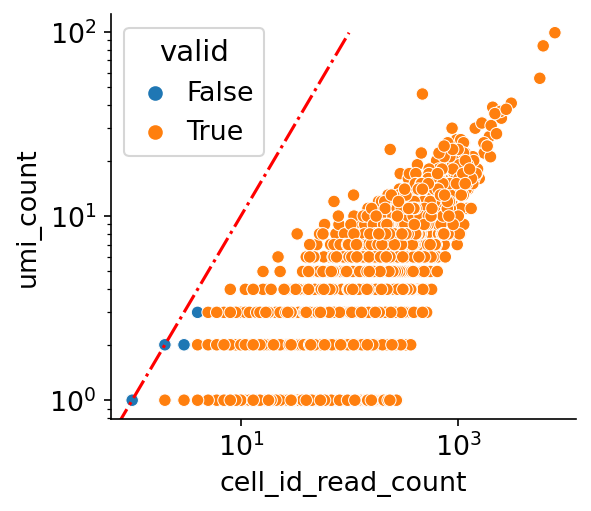

In [11]:
df_valid_cells=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=1.5,cell_key="cell_id",)

In [12]:
df_valid_cells

,cell_id,cell_id_read_count,umi_count,valid
0,5FU_FO892_4_AAACCCAGTGATAGAT,5,1,True
1,5FU_FO892_4_AAACCCATCAGCGGAA,55,5,True
2,5FU_FO892_4_AAACCCATCGCACTCT,231,4,True
3,5FU_FO892_4_AAACCCATCGCTGTTC,450,9,True
4,5FU_FO892_4_AAACCCATCGGTTGTA,201,6,True
...,...,...,...,...
3969,5FU_FO892_4_TTTGTTGAGCTGTTCA,304,8,True
3970,5FU_FO892_4_TTTGTTGAGGGTAATT,385,5,True
3971,5FU_FO892_4_TTTGTTGAGTAGATCA,109,13,True
3972,5FU_FO892_4_TTTGTTGCACGATTCA,395,9,True


In [13]:
df = pd.DataFrame(df_valid_cells)
df.to_csv(output_dir+sample+'.csv', index=False)

We are interested to see at what read cutoff the corresponding cell number or clone number conform to our expectation. 

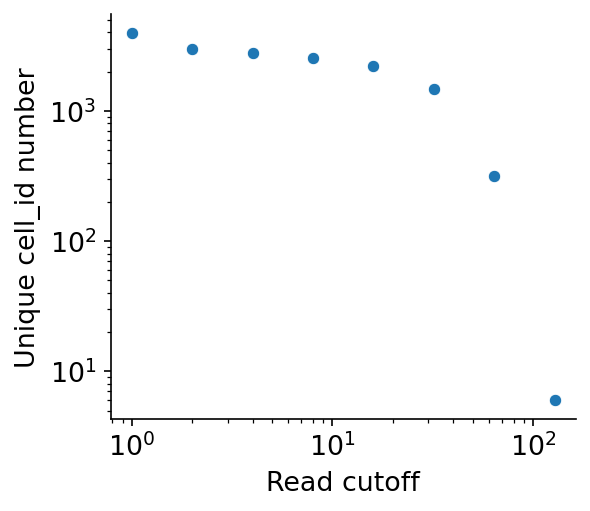

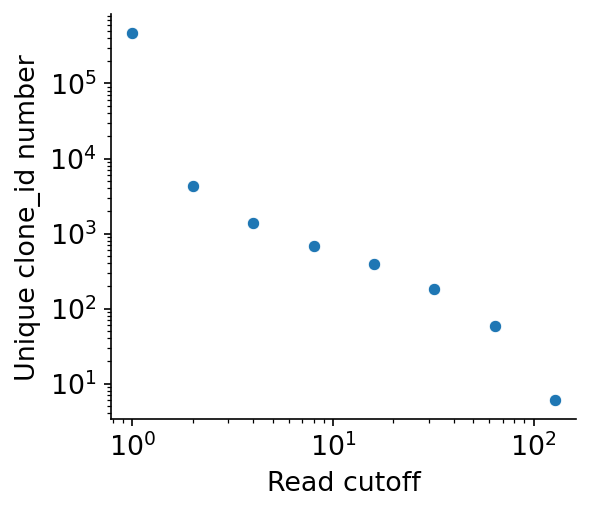

In [14]:
df_unique=larry.QC_unique_cells(df_filter_reads,target_keys=['cell_id','clone_id'])

In [15]:
larry.print_statistics(df_filter_reads)

library number: 1
cell_id number: 3974
clone_id number: 475399
umi_id number: 19343
total reads: 812K


## Collapse clone_id and filter cells within the same clone_id length

We first perform barcode cleaning within a certian distance, then re-calculate the read number, and filter out low-read-count sequences. The read threshold is determined as the 10% of the max read count within each sequence length group, with a lower bound at coarse_grained_readcutoff_floor

In [16]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
read_cutoff=2 # initial read count filtering 
# coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
# distance_relative_threshold=0.05 # 5% error rate, will be multipled with the sequence length
    
# use a low-filtering threshold, and also avoid filtering out valid_cell ids from above
def filter_low_read_cells(df,coarse_grained_readcutoff=None):
    if coarse_grained_readcutoff is None:
        coarse_grained_readcutoff=np.max([coarse_grained_readcutoff_floor,0.01*df['read'].max()])
    return df[(df['read']>=coarse_grained_readcutoff) | df['cell_id'].isin(df_valid_cells['cell_id'].unique())]

df_list=[]
unique_seq_length=list(set(df_filter_reads['bc_length']))
for target_length in sorted(unique_seq_length):
    df_tmp=df_filter_reads[df_filter_reads['bc_length']==target_length]#.groupby(['cell_bc','clone_id']).agg({'read':'sum'})
    df_HQ=larry.denoise_clonal_data(df_tmp,
        target_key="clone_id",
        denoise_method="UMI_tools",  # UMI_tools, 'Hamming'
        distance_threshold=1, #np.max([1,int(target_length*distance_relative_threshold)]),      
        read_cutoff=read_cutoff,
        whiteList=None,
        plot_report=False,
        progress_bar=False)

    df_HQ_group=larry.group_cells(df_HQ,group_keys=["library","cell_id","cell_bc","clone_id"])
    df_out=df_HQ_group.groupby('clone_id',group_keys=True).apply(filter_low_read_cells).reset_index(drop=True)
    df_out['bc_length']=target_length
    df_list.append(df_out)
df_denoise_bc_1=pd.concat(df_list)

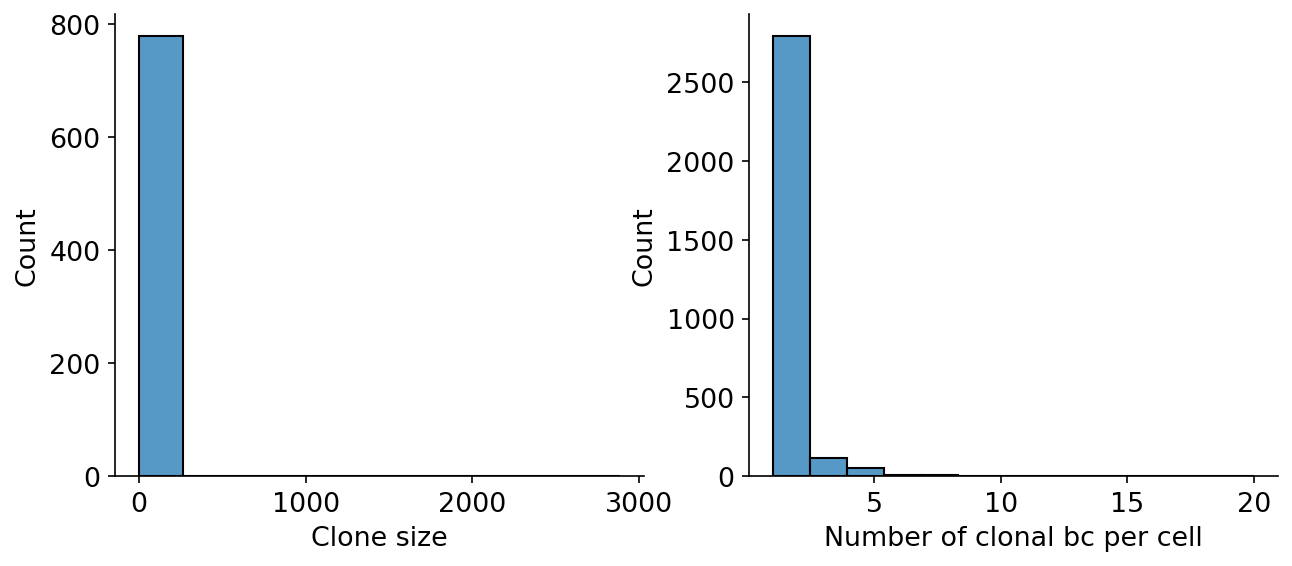

In [17]:
larry.QC_clonal_reports(df_denoise_bc_1)

## Select dominant clone_id within each cell_id

The above operation leaves some cell barcodes to have multiple clone barcodes. We select the read-dominant clonal barcodes as the putative clone id for each cell barcode.

seq length


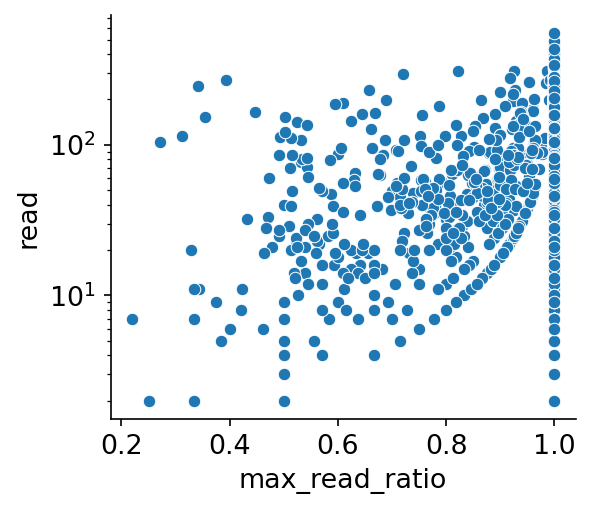

In [18]:
# select dominant barcode sequence within each cell barcode, we use a very high read_ratio to avoid false positive
#df_dominant_frac=car.calculate_read_fraction_for_dominant_sequences(df_denoise_bc_2,cell_bc_key='cell_bc',clone_key='clone_id')
df_dominant=larry.obtain_read_dominant_sequences(df_denoise_bc_1,cell_bc_key='cell_bc',clone_key='clone_id')
sns.scatterplot(data=df_dominant,x='max_read_ratio',y='read')
plt.yscale('log')